# Watermarking and Steganography
 

### Notations:

* X = matrix of $N_{i}$ original vectors of size $N_{v}$ ($N_{i}$ columns, $N_{v}$ rows). $N_{i}$ represents, for example, the number of processed content, and $N_{v}$ the number of components watermarked per content. Note: each column of X can, for example, represent components of an image.
* $N_{o}$ represents the number of observed watermarked contents by the adversary and used to build their attack.
* $N_{i}$ represents the number of watermarked contents used to practically calculate the error rate (see BER).
* Y = matrix of watermarked contents.
* Z = matrix of watermarked and disturbed contents.
* k secret key of unit norm.
* $m_{1}$: inserted bit, converted to +1, -1.
* $\alpha$: distortion parameter.
* BER: Bit Error Rate, binary error rate or empirical decoding error probability.

### Context:
* The receiver's objective is to decode $m_{1}$ (and possibly $m_{2}$) correctly, possibly with a not too significant distortion.
* Here, the adversary's objectives are to estimate the key k and then erase the inserted message. To ensure that the adversary has successfully estimated the key, they will calculate the normalized correlation between the vector k and their estimation.


In [1]:
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from sklearn.decomposition import FastICA
from PIL import Image
import math
from scipy import signal
import matplotlib.image as mpimg
import random
import statistics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, confusion_matrix

## Watermarking an Image (Before Watermarking Gaussian Signals)

* Increasing the value of $\alpha$, from what value does it start to become visible?
    A difference can be observed from a value of $\alpha$ of 512*20 (over the entire image).
* Test the robustness to the addition of noise (averaging over multiple insertions/decodings).
* Test the robustness compared to a low-pass filter.

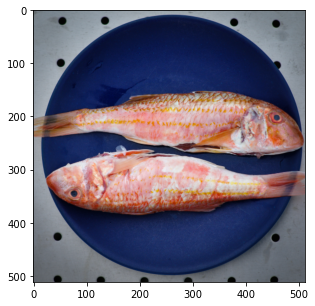

In [3]:
#Display the original image
image_path = './red_fish.png'
pil_image = Image.open(image_path)


im_array = np.asarray(pil_image)
im_w = np.copy(im_array)

plt.figure(1,figsize=(5,5))
plt.imshow(im_array)

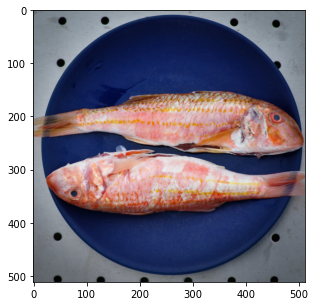

In [4]:
# Extracting the blue channel from the image array
blue_channel = im_array[:,:,2]

# Generating random keys k1 and k2 for spread spectrum embedding
k1 = np.random.randn(512,512)
k1 = k1/np.linalg.norm(k1) # Normalizing k1

k2 = np.random.randn(512,512)
k2 = k2/np.linalg.norm(k2) # Normalizing k2

# Setting the embedding strength parameter alpha
alpha = 512

# Insertion of 1 and 0 into the blue channel
blue_channel_w = blue_channel.astype(float) + np.round(alpha*k1) - np.round(alpha*k2)

# Clipping values to ensure they remain within the valid range [0, 255]
blue_channel_w[blue_channel_w>255]=255
blue_channel_w[blue_channel_w<0]=0

# Updating the modified blue channel in the image array
im_w[:,:,2] = blue_channel_w

# Displaying the watermarked image
plt.figure(1,figsize=(5,5))
plt.imshow(im_w)


Decoding errors: 0


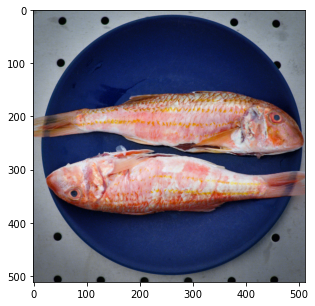

In [5]:
# Noise insertion and robustness testing
blue_channel = im_array[:,:,2]  # Extracting the blue channel from the image array
alpha = 512  # Setting the embedding strength parameter alpha
blue_channel_w = blue_channel.astype(float)  # Converting the blue channel to float for manipulation

# Generating a sequence of bits to insert and corresponding keys
nb_bits = 50  # Number of bits to insert
bits = [np.random.randint(0, 2) for i in range(nb_bits)]  # Generating random bits (0 or 1)
bits = np.array(bits)
bits[bits < 1] = -1  # Converting 0s to -1s for spread spectrum embedding
keys = []  # List to store generated keys
for bit in bits:
    key = np.random.randn(512, 512)  # Generating a random key
    key = key / np.linalg.norm(key)  # Normalizing the key
    keys.append(key)

# Watermarking
for i in range(len(bits)):
    blue_channel_w = blue_channel_w + np.round(bits[i] * alpha * keys[i])  # Spread spectrum embedding

# Clipping values to ensure they remain within the valid range [0, 255]
blue_channel_w[blue_channel_w > 255] = 255
blue_channel_w[blue_channel_w < 0] = 0

# Decoding the embedded message
decoded_msg = []
for key in keys:
    scalar_product = np.dot(blue_channel_w.flatten(), key.flatten())
    decoded_msg.append(math.copysign(1, scalar_product))  # Decoding the embedded bit
decoded_msg = np.array(decoded_msg).astype(int)

# Counting decoding errors
print('Decoding errors:', np.count_nonzero((decoded_msg == bits) == False))

# Updating the modified blue channel in the image array
im_w[:,:,2] = blue_channel_w

# Displaying the watermarked image
plt.figure(1, figsize=(5, 5))
plt.imshow(im_w)

In [6]:
# Noise addition and detection
for i in [1, 10, 100, 1000, 5000]:  # Looping through different noise amplitudes
    blue_channel_noise = blue_channel_w.copy()  # Creating a copy of the watermarked blue channel
    beta = 512 * i  # Setting the noise strength parameter beta
    key = np.random.randn(512, 512)  # Generating a random key
    key = key / np.linalg.norm(key)  # Normalizing the key
    blue_channel_noise = blue_channel_noise + np.round(beta * key)  # Adding noise to the blue channel

    # Clipping values to ensure they remain within the valid range [0, 255]
    blue_channel_noise[blue_channel_noise > 255] = 255
    blue_channel_noise[blue_channel_noise < 0] = 0

    decoded_msg = []
    for key in keys:
        scalar_product = np.dot(blue_channel_noise.flatten(), key.flatten())
        decoded_msg.append(math.copysign(1, scalar_product))  # Decoding the embedded bit
    decoded_msg = np.array(decoded_msg).astype(int)

    # Counting decoding errors for the current noise amplitude
    print('Decoding errors for noise amplitude', i, ':', np.count_nonzero((decoded_msg == bits) == False))

Decoding errors for noise amplitude 1 : 0
Decoding errors for noise amplitude 10 : 0
Decoding errors for noise amplitude 100 : 0
Decoding errors for noise amplitude 1000 : 17
Decoding errors for noise amplitude 5000 : 19


#### Exemple of blur filtering

Original Image


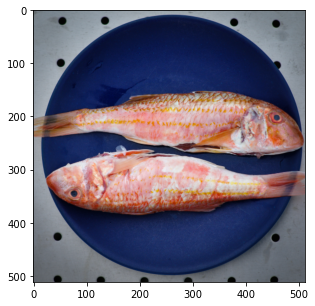

-174.6548342447427
63.549661869134376
Image with Filter of Size 1


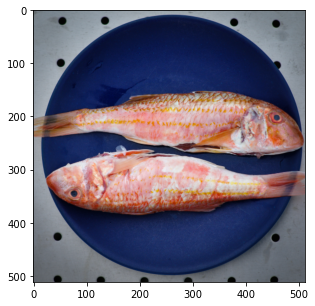

-174.6548342447427
63.549661869134376
Image with Filter of Size 5


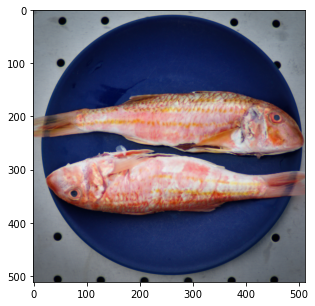

-163.19747797028563
73.92820479870714
Image with Filter of Size 10


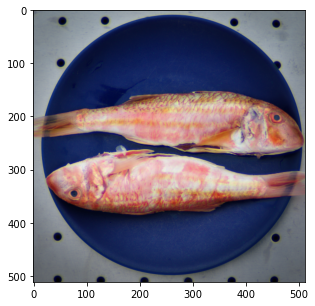

-152.49879781880833
67.65688347056488
Image with Filter of Size 20


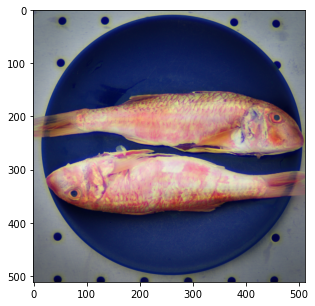

-160.67943763617836
59.45073590925655


In [7]:
print("Original Image")
im_w = np.copy(im_array)

plt.figure(1, figsize=(5,5))
plt.imshow(im_w)
plt.show()

print(np.dot(im_w[:,:,2].flatten(), k1.flatten()))  # Dot product of blue channel with key k1
print(np.dot(im_w[:,:,2].flatten(), k2.flatten()))  # Dot product of blue channel with key k2

for i in [1, 5, 10, 20]:  # Looping through different filter sizes
    print("Image with Filter of Size " + str(i))
    im_w = np.copy(im_array)
    im_w_filter = signal.convolve2d(im_w[:,:,2], np.ones((i, i))/(i**2), boundary='symm', mode='same')  # Applying a filter
    im_w[:,:,2] = im_w_filter
    plt.figure(1, figsize=(5,5))
    plt.imshow(im_w)
    plt.show()
    print(np.dot(im_w_filter.flatten(), k1.flatten()))  # Dot product of filtered blue channel with key k1
    print(np.dot(im_w_filter.flatten(), k2.flatten()))  # Dot product of filtered blue channel with key k2


We can see that the scalar products between the modified images and the key become more distant as we increase the size of the low-pass filter.

# Security attack

## Scenario 1: Known Message Attack, 1 bit
* Initialization: What is the adversary's target Bit Error Rate (BER)?
* Implement the attack related to this scenario.
* Investigate the impact of $N_{o}$ and $\alpha$ on the BER after the attack.

The opponent's target BER is 0.5, which corresponds to overall indifference.

In [8]:
Nv = 100 # Size of the vector
Ni = 10000 # Max number of observations

In [10]:
def ber(Y, m, k):
    # Compute the Bit Error Rate between message m and the extracted message from Y using key k
    c = np.sign(np.dot(Y.T, k))
    return np.sum(c != m) / float(Ni)

def norm_corr(hatk, k):
    # Normalize the estimated key
    hatk = hatk / np.sqrt(np.dot(hatk.T, hatk))
    # Compute the normalized correlation between the estimated key and the true key
    corrN = np.abs(np.dot(hatk.T, k)) / (np.linalg.norm(hatk) * np.linalg.norm(k))
    return corrN

def do_process(alpha, No):
    print('alpha: ', alpha)
    print('No: ', No)

    # Generate Ni random host vectors
    X = np.random.randn(Nv, Ni)
    # Generate the Watermark
    k = np.random.randn(Nv, 1)
    # Normalize the watermark
    k = k / np.sqrt(np.dot(k.T, k))

    # Scenario with Known Messages: generate only ones
    m1 = np.ones((Ni, 1))

    # Generate the matrix of watermarks (each column contains m1_i*k)
    K = np.dot(k, m1.T)

    # Generate the watermark signal
    W = alpha * K

    # Perform embedding
    Y = X + W

    # Compute the practical bit error rate
    cY = np.sign(np.dot(Y.T, k))
    print('practical bit error rate:', np.sum(cY != m1) / float(Ni))

    # Select observed tattooed contents
    Y_obs = Y[:, :No]

    # Estimate the key from the observed contents
    hatk = np.zeros(Nv)
    for y in Y_obs.T:
        hatk = hatk + y
    hatk = hatk / (alpha * No)
    # Normalize the estimated key
    hatk = hatk / np.sqrt(np.dot(hatk.T, hatk))

    # Compute the normalized correlation between the true key and the estimated key
    corrN = np.abs(np.dot(hatk.T, k)) / (np.linalg.norm(hatk) * np.linalg.norm(k))
    print('Normalised correlation between the true key and the estimated key:', corrN)

    # Reshape the estimated key
    hatk = np.reshape(hatk, (Nv, 1))

    # Perform the removal attack
    YA = Y - alpha * np.dot(hatk, m1.T)
    # Compute the practical bit error rate after the security attack
    print('practical bit error rate after security attack: ', ber(YA, m1, k), '\n')

    return ber(YA, m1, k)

alpha = 2  # Tune the power of the watermark here


alpha:  2
No:  100
practical bit error rate: 0.0234
Normalised correlation between the true key and the estimated key: [0.91046845]
practical bit error rate after security attack:  0.4348 

alpha:  2
No:  400
practical bit error rate: 0.0223
Normalised correlation between the true key and the estimated key: [0.96893133]
practical bit error rate after security attack:  0.4772 

alpha:  2
No:  700
practical bit error rate: 0.0215
Normalised correlation between the true key and the estimated key: [0.98281714]
practical bit error rate after security attack:  0.4857 

alpha:  2
No:  1000
practical bit error rate: 0.0235
Normalised correlation between the true key and the estimated key: [0.986804]
practical bit error rate after security attack:  0.4911 

alpha:  2
No:  1300
practical bit error rate: 0.0231
Normalised correlation between the true key and the estimated key: [0.99055488]
practical bit error rate after security attack:  0.492 

alpha:  2
No:  1600
practical bit error rate: 0.021

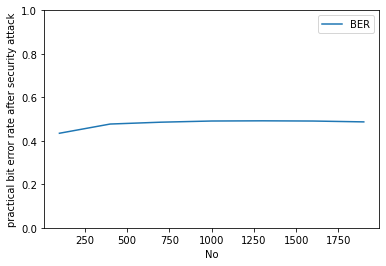

alpha:  1
No:  2000
practical bit error rate: 0.155
Normalised correlation between the true key and the estimated key: [0.97165048]
practical bit error rate after security attack:  0.4907 

alpha:  3
No:  2000
practical bit error rate: 0.0006
Normalised correlation between the true key and the estimated key: [0.99696373]
practical bit error rate after security attack:  0.4985 

alpha:  5
No:  2000
practical bit error rate: 0.0
Normalised correlation between the true key and the estimated key: [0.99928539]
practical bit error rate after security attack:  0.5046 

alpha:  7
No:  2000
practical bit error rate: 0.0
Normalised correlation between the true key and the estimated key: [0.99957855]
practical bit error rate after security attack:  0.5028 

alpha:  9
No:  2000
practical bit error rate: 0.0
Normalised correlation between the true key and the estimated key: [0.99966384]
practical bit error rate after security attack:  0.4968 



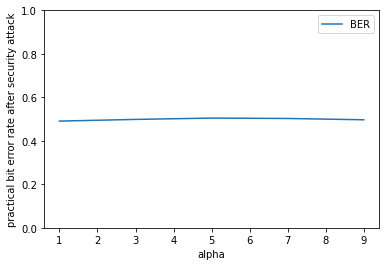

In [11]:
x = []
y = []

# Vary the number of observed tattooed contents
for No in range(100, 2000, 300):
    y.append(do_process(alpha, No))
    x.append(No)
x = np.array(x)
y = np.array(y)
plt.xlabel("No")
plt.ylabel("practical bit error rate after security attack")
plt.plot(x, y, label='BER')
plt.legend()
axes = plt.gca()
axes.set_ylim(0, 1)
plt.show()

x = []
y = []

# Vary the embedding strength alpha
for alpha in range(1, 10, 2):
    y.append(do_process(alpha, 2000))
    x.append(alpha)
x = np.array(x)
y = np.array(y)
plt.xlabel("alpha")
plt.ylabel("practical bit error rate after security attack")
plt.plot(x, y, label='BER')
axes = plt.gca()
axes.set_ylim(0, 1)
plt.legend()
plt.show()

## Scenario 2: Unknown Message Attack, 1 bit

* Note: the `np.linalg.eig` function can be used to perform an eigenvalue and eigenvector decomposition.
* Note: to erase the inserted message, it will be necessary to estimate the inserted "bit" beforehand (m=-1 or m=1), this can be done via `m_est = np.sign(np.dot(Y.T,hatk))` where `hatk` is the estimated key.
* Implement the attack.
* Study the impact of $N_{o}$ and $\alpha$ on the BER after the attack.

2nd Scenario
alpha:  2
No:  100
Normalised correlation between the true key and the estimated key:  [[0.87840061]]
bit error rate after security attack:  0.3681 

alpha:  2
No:  400
Normalised correlation between the true key and the estimated key:  [[0.96433464]]
bit error rate after security attack:  0.4412 

alpha:  2
No:  700
Normalised correlation between the true key and the estimated key:  [[0.98007164]]
bit error rate after security attack:  0.4557 

alpha:  2
No:  1000
Normalised correlation between the true key and the estimated key:  [[0.98528332]]
bit error rate after security attack:  0.4513 

alpha:  2
No:  1300
Normalised correlation between the true key and the estimated key:  [[0.98651761]]
bit error rate after security attack:  0.4628 

alpha:  2
No:  1600
Normalised correlation between the true key and the estimated key:  [[0.98897459]]
bit error rate after security attack:  0.4653 

alpha:  2
No:  1900
Normalised correlation between the true key and the estimated ke

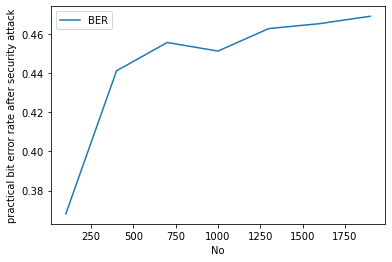

alpha:  1
No:  2000
Normalised correlation between the true key and the estimated key:  [[0.94021679]]
bit error rate after security attack:  0.3323 

alpha:  3
No:  2000
Normalised correlation between the true key and the estimated key:  [[0.99685144]]
bit error rate after security attack:  0.4999 

alpha:  5
No:  2000
Normalised correlation between the true key and the estimated key:  [[0.99895645]]
bit error rate after security attack:  0.4945 

alpha:  7
No:  2000
Normalised correlation between the true key and the estimated key:  [[0.99952648]]
bit error rate after security attack:  0.4913 

alpha:  9
No:  2000
Normalised correlation between the true key and the estimated key:  [[0.99960812]]
bit error rate after security attack:  0.4988 



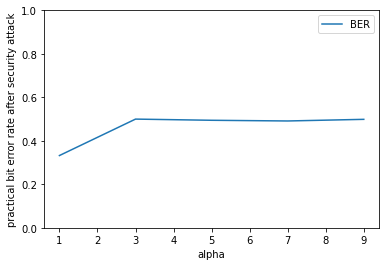

In [12]:
print('2nd Scenario')

def do_process2(alpha, No):
    
    print('alpha: ', alpha)
    print('No: ', No)

    # Generate Ni random host vectors
    X = np.random.randn(Nv, Ni)
    # Generate the Watermark
    k = np.random.randn(Nv, 1)
    # Normalize the watermark
    k = k / np.sqrt(np.dot(k.T, k))

    # Scenario with unknown messages, first bit
    m1 = np.sign(np.random.randn(Ni, 1))

    # Generate the matrix of watermarks (each column contains m1_i*k)
    K = np.dot(k, m1.T)

    # Generate the watermark signal
    W = alpha * K

    # Perform embedding
    Y = X + W
    
    Y_obs = Y[:, :No]

    # Estimate the key using KMA (Karhunen-Loève expansion)
    hatk = np.zeros(Nv)
    cov = np.dot(Y_obs, Y_obs.T)
    valP, vectP = np.linalg.eig(cov)
    hatk = vectP[:, 0]
    hatk = np.reshape(hatk, (Nv, 1))  # Reshape the estimated key
    # Compute the normalized correlation between the true key and the estimated key
    corrN = norm_corr(hatk, k)
    print('Normalised correlation between the true key and the estimated key: ', corrN)
    hatk = hatk / np.sqrt(np.dot(hatk.T, hatk))
    # Estimate the inserted bit
    m_est = np.sign(np.dot(Y.T, hatk))
    # Perform the removal attack
    YA = Y - alpha * np.dot(hatk, m_est.T)

    print('bit error rate after security attack: ', ber(YA, m1, k), '\n')
    
    return ber(YA, m1, k)

alpha = 2  # Tune the power of the watermark here

x = []
y = []

# Vary the number of observed tattooed contents
for No in range(100, 2000, 300):
    y.append(do_process2(alpha, No))
    x.append(No)
x = np.array(x)
y = np.array(y)
plt.xlabel("No")
plt.ylabel("practical bit error rate after security attack")
plt.plot(x, y, label='BER')
plt.legend()
plt.show()

x = []
y = []

# Vary the embedding strength alpha
for alpha in range(1, 10, 2):
    y.append(do_process2(alpha, 2000))
    x.append(alpha)
x = np.array(x)
y = np.array(y)
plt.xlabel("alpha")
plt.ylabel("practical bit error rate after security attack")
axes = plt.gca()
axes.set_ylim(0, 1)
plt.plot(x, y, label='BER')
plt.legend()
plt.show()


We notice that increasing the value of $N_o$ improves the performance of the attack.
A low value of $\alpha$ increases security.

## Scenario 3: Unknown Message Attack, 2 bits

* Verify that the previous attack does not allow the estimation of both keys.
* Estimate at least one of the keys used.
    * Note: the `FastICA` algorithm can be used to estimate the two independent components.
    * For this, you can call the `fastica` function specifying that the independent component analysis will be performed on a subspace generated by the *first two principal components* (`n_components=2`), and by retrieving the columns of the mixing matrix A (obtained via `ica.mixing_`) estimated by the algorithm.
    * Check, using normalized correlation, that this method allows the estimation of key `k1`.
* Implement the attack that allows for both bits.
* Study the impact of $N_{o}$ and $\alpha$ on the BER after the attack.

3rd scenario, 2 bits
Testing scenario 2 with a 2 bits message
alpha:  2
No:  100
bit error rate after security attack for the first bit: 0.2936
bit error rate after security attack for the second bit: 0.2563


alpha:  2
No:  400
bit error rate after security attack for the first bit: 0.3181
bit error rate after security attack for the second bit: 0.3221


alpha:  2
No:  700
bit error rate after security attack for the first bit: 0.3785
bit error rate after security attack for the second bit: 0.3841


alpha:  2
No:  1000
bit error rate after security attack for the first bit: 0.3324
bit error rate after security attack for the second bit: 0.3263


alpha:  2
No:  1300
bit error rate after security attack for the first bit: 0.3392
bit error rate after security attack for the second bit: 0.3301


alpha:  2
No:  1600
bit error rate after security attack for the first bit: 0.3413
bit error rate after security attack for the second bit: 0.3237


alpha:  2
No:  1900
bit error rate after securi

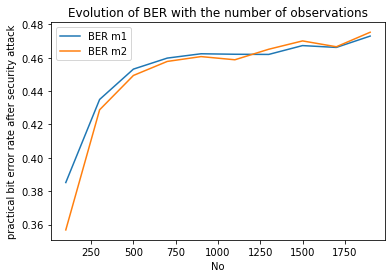

alpha:  1
No:  2000
bit error rate after security attack for the first bit: 0.3384
bit error rate after security attack for the second bit: 0.3385


alpha:  3
No:  2000
bit error rate after security attack for the first bit: 0.5016
bit error rate after security attack for the second bit: 0.4945


alpha:  5
No:  2000
bit error rate after security attack for the first bit: 0.5013
bit error rate after security attack for the second bit: 0.4967


alpha:  7
No:  2000
bit error rate after security attack for the first bit: 0.5049
bit error rate after security attack for the second bit: 0.49


alpha:  9
No:  2000
bit error rate after security attack for the first bit: 0.4978
bit error rate after security attack for the second bit: 0.493




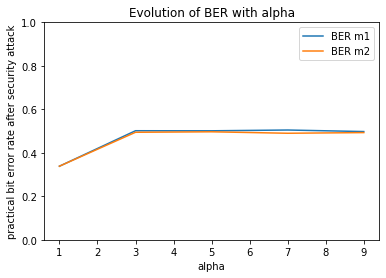

In [13]:
# 3rd scenario, 2 bits
print('3rd scenario, 2 bits')

# Generate unknown messages
m1 = np.sign(np.random.randn(Ni,1))  # Scenario with unknown messages, first bit
m2 = np.sign(np.random.randn(Ni,1))  # Scenario with unknown messages, second bit

# Generate watermarks and normalize
k1 = np.random.randn(Nv,1)
k1 = k1 / np.sqrt(np.dot(k1.T, k1))
k2 = np.random.randn(Nv,1)
k2 = k2 / np.sqrt(np.dot(k2.T, k2))

def do_process2(alpha, No):
    print('alpha: ', alpha)
    print('No: ', No)

    # Generate Ni random host vectors
    X = np.random.randn(Nv, Ni)

    # Generate the matrix of watermarks (each column contains m1_i*k)
    K = np.dot(k1, m1.T) + np.dot(k2, m2.T)

    # Generate the watermark signal
    W = alpha * K

    # Perform embedding
    Y = X + W

    # Take the observed part
    Y_obs = Y[:, :No]

    # Estimate the key using PCA
    hatk1, hatk2 = np.zeros(Nv), np.zeros(Nv)
    cov = np.dot(Y_obs, Y_obs.T)
    valP, vectP = np.linalg.eig(cov)
    hatk1 = vectP[:, 0]
    hatk1 = np.reshape(hatk1, (Nv, 1))
    hatk2 = vectP[:, 1]
    hatk2 = np.reshape(hatk2, (Nv, 1))
    
    # Normalize the estimated keys
    hatk1 = hatk1 / np.sqrt(np.dot(hatk1.T, hatk1))
    hatk2 = hatk2 / np.sqrt(np.dot(hatk2.T, hatk2))
    
    # Estimate the inserted bits
    m1_est = np.sign(np.dot(Y.T, hatk1))
    m2_est = np.sign(np.dot(Y.T, hatk2))
    
    # Perform the removal attack
    YA = Y - alpha * np.dot(hatk1, m1_est.T) - alpha * np.dot(hatk2, m2_est.T)

    # Print the bit error rate after security attack
    print('bit error rate after security attack for the first bit:', ber(YA, m1, k1))
    print('bit error rate after security attack for the second bit:', ber(YA, m2, k2))
    print('\n')

def do_process3(alpha, No):
    print('alpha: ', alpha)
    print('No: ', No)

    # Generate Ni random host vectors
    X = np.random.randn(Nv, Ni)

    # Generate the matrix of watermarks (each column contains m1_i*k)
    K = np.dot(k1, m1.T) + np.dot(k2, m2.T)

    # Generate the watermark signal
    W = alpha * K

    # Perform embedding
    Y = X + W

    # Take the observed part
    Y_obs = Y[:, :No]

    # Perform FastICA to estimate the keys
    ica = FastICA(n_components=2)
    S = ica.fit_transform(Y_obs.T)
    A = ica.mixing_
    hatk_1 = A[:, 0]
    hatk_1 = hatk_1 / np.linalg.norm(hatk_1)
    hatk_1 = np.reshape(hatk_1, (Nv, 1))
    hatk_2 = A[:, 1]
    hatk_2 = hatk_2 / np.linalg.norm(hatk_2)
    hatk_2 = np.reshape(hatk_2, (Nv, 1))
    
    # Estimate the inserted bits
    m1_est = np.sign(np.dot(Y.T, hatk_1))
    m2_est = np.sign(np.dot(Y.T, hatk_2))
    
    # Perform the removal attack
    YA_1 = Y - alpha * np.dot(hatk_1, m1_est.T) - alpha * np.dot(hatk_2, m2_est.T)
    
    # Calculate the bit error rates after the security attack for both bits
    ber_m1 = ber(YA_1, m1, k1)
    ber_m2 = ber(YA_1, m2, k2)
    
    print('bit error rate after security attack for the first bit:', ber_m1)
    print('bit error rate after security attack for the second bit:', ber_m2)
    print('\n')
    
    return ber_m1, ber_m2


alpha = 2  # Tune the power of the watermark here

# Test scenario 2 with a 2 bits message
print('Testing scenario 2 with a 2 bits message')
for No in range(100, 2000, 300):
    do_process2(alpha, No)
print('\n\nImplementation of FastICA\n\n')

# Plot BER evolution with the number of observations
x = []
y1 = []
y2 = []
for No in range(100, 2000, 200):
    y = do_process3(alpha, No)
    y1.append(y[0])
    y2.append(y[1])
    x.append(No)
x = np.array(x)
y1 = np.array(y1)
y2 = np.array(y2)
plt.xlabel("No")
plt.ylabel("practical bit error rate after security attack")
plt.title('Evolution of BER with the number of observations')
plt.plot(x, y1, label='BER m1')
plt.plot(x, y2, label='BER m2')
plt.legend()
plt.show()

# Plot BER evolution with alpha
x = []
y1 = []
y2 = []
for alpha in range(1, 10, 2):
    y = do_process3(alpha, 2000)
    y1.append(y[0])
    y2.append(y[1])
    x.append(alpha)
x = np.array(x)
y1 = np.array(y1)
y2 = np.array(y2)
plt.xlabel("alpha")
plt.ylabel("practical bit error rate after security attack")
plt.title('Evolution of BER with alpha')
axes = plt.gca()
axes.set_ylim([0, 1])
plt.plot(x, y1, label='BER m1')
plt.plot(x, y2, label='BER m2')
plt.legend()
plt.show()


- We notice that the method of the second scenario is not efficient in finding the 2 keys because the BER does not converge.
- The normalized correlation shows that the method allows estimating the keys.
- The results with ICA are better because we converge towards a BER of 0.5.

## Conclusion: Robustness Study

* Calculate the theoretical Bit Error Rate (BER) after adding noise.
* Study the evolution of robustness (via BER) as a function of distortion (via $\alpha$).
* What compromise do we observe between security and robustness?


Beta: 0


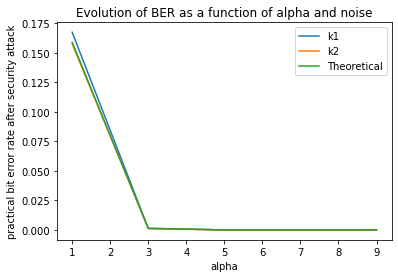

Beta: 2


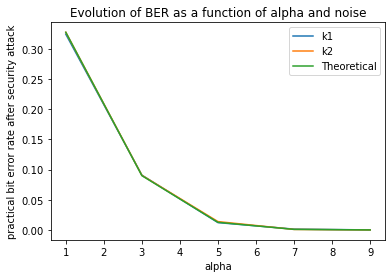

Beta: 4


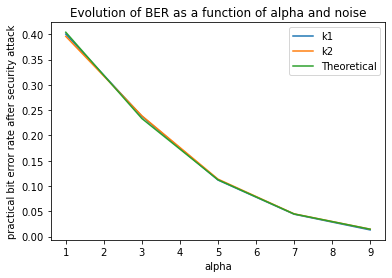

Beta: 6


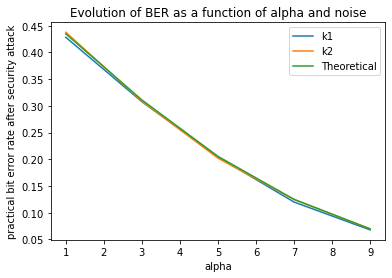

Beta: 8


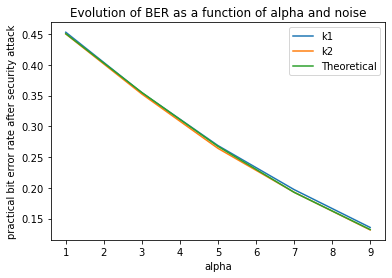

In [14]:
# Theoretical Noise Calculation

k1 = np.random.randn(Nv,1) # Generate the Watermark
k1 = k1 / np.sqrt(np.dot(k1.T,k1)) # Normalize the watermark

k2 = np.random.randn(Nv,1) # Generate the Watermark
k2 = k2 / np.sqrt(np.dot(k2.T,k2)) # Normalize the watermark

def do_process_noise(alpha, No, beta):
    X = np.random.randn(Nv, Ni) # Generate Ni random host vectors

    K = np.dot(k1, m1.T) + np.dot(k2, m2.T) # Generate the matrix of watermarks (each column contains m1_i*k)
    noise = beta * np.random.randn(Nv, Ni)
    W = alpha * K

    Y = X + W + noise # perform embedding

    # Theoretical noise calculation
    var_X = np.var(X)
    var_noise = np.var(noise)
    error = (1 + erf(-alpha / math.sqrt(2 * (var_X + var_noise)))) / 2

    return [ber(Y, m1, k1), ber(Y, m2, k2), error]


for beta in range(0, 10, 2):
    print('Beta:', beta)
    x = []
    y1 = []
    y2 = []
    y3 = []
    for alpha in range(1, 10, 2):
        y = do_process_noise(alpha, 2000, beta)
        y1.append(y[0])
        y2.append(y[1])
        y3.append(y[2])
        x.append(alpha)
    x = np.array(x)
    y1 = np.array(y1)
    y2 = np.array(y2)
    y3 = np.array(y3)
    plt.xlabel("alpha")
    plt.ylabel("practical bit error rate after security attack")
    plt.title('Evolution of BER as a function of alpha and noise')
    plt.plot(x, y1, label='k1')
    plt.plot(x, y2, label='k2')
    plt.plot(x, y3, label='Theoretical')
    plt.legend()
    plt.show()


- Increasing $\alpha$ leads to a decrease in the BER as expected, while increasing the noise amplitude leads to an increase in the BER.

- Indeed, we observe a trade-off between security and robustness. A low value of $\alpha$ provides better security against the attacks we have implemented. However, the message is much less robust to the addition of noise. A high value of $\alpha$ reverses these characteristics: robust but low security.

# LSBR steganography steganalysis

#### Message insertion

In [15]:
# Message to embedd
#message = 'The skills of the SIGMA team are based on solid foundations in statistics and geometry. Its members are interested in mathematical objects extracted from physical measurements such as images, polarized light, sounds, videos, or even chemical or turbulence sensors. These signals and their properties are treated using Bayesian formalism, belief function theory, information geometry, or information theory. With the common denominator being the treatment and statistical modeling of signals, our research activities are part of communities related to Bayesian inference, evidential decision theory, polarimetric imaging, or information security. The SIGMA team also relies on strong relationships with the Decision and Data Analysis master's program at École Centrale Lille and the statistical signal processing option at Telecom-Lille. Illustrations of our research include Bayesian inference and Monte Carlo methods: tracking of video objects, inverse modeling (retrieval of source data), data fusion: decision-making from a sensor network, information security: intrusion and weak signal detection; automatic authentication of printed documents, polarimetric imaging: artifact detection on materials.'

message = 'CRIStAL (Center for Research in Computing, Signal, and Automatics of Lille) is a mixed research unit (UMR 9189) resulting from the merger of LAGIS (Laboratory of Automatics, Computer Engineering, and Signal - UMR 8219) and LIFL (Laboratory of Fundamental Computer Science of Lille - UMR 8022) to bring together their complementary skills in information sciences. CRIStAL was born on January 1, 2015, under the supervision of CNRS, University of Lille 1, and École Centrale de Lille in partnership with University of Lille 3, Inria, and Institut Mines Telecom. CRIStAL is a member of the interdisciplinary research institute IRCICA – USR CNRS 3380 (www.ircica.univ-lille1.fr). The unit consists of nearly 430 members (222 permanent and over 200 non-permanent), including 22 permanent CNRS members and 27 permanent Inria members. The research activities of CRIStAL focus on themes related to current major scientific and societal challenges such as Big Data, software, image and its uses, human-machine interactions, robotics, control and supervision of large systems, intelligent embedded systems, bioinformatics... with applications notably in the sectors of commerce industry, technologies for health, and smart grids.'

# Key 
key = 'azerty'

print(message)

CRIStAL (Center for Research in Computing, Signal, and Automatics of Lille) is a mixed research unit (UMR 9189) resulting from the merger of LAGIS (Laboratory of Automatics, Computer Engineering, and Signal - UMR 8219) and LIFL (Laboratory of Fundamental Computer Science of Lille - UMR 8022) to bring together their complementary skills in information sciences. CRIStAL was born on January 1, 2015, under the supervision of CNRS, University of Lille 1, and École Centrale de Lille in partnership with University of Lille 3, Inria, and Institut Mines Telecom. CRIStAL is a member of the interdisciplinary research institute IRCICA – USR CNRS 3380 (www.ircica.univ-lille1.fr). The unit consists of nearly 430 members (222 permanent and over 200 non-permanent), including 22 permanent CNRS members and 27 permanent Inria members. The research activities of CRIStAL focus on themes related to current major scientific and societal challenges such as Big Data, software, image and its uses, human-machine

### Loading the COVER image

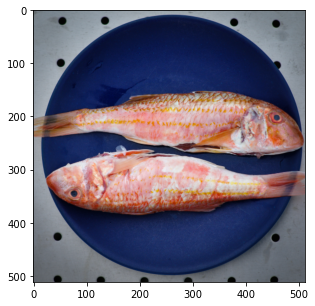

In [16]:
# Cover file
image_path = './red_fish.png'
# Stego file
stego_path = './stego.png'

# Open and show the figure
pil_image = Image.open(image_path)
im_array = np.asarray(pil_image)
im_stego = np.copy(im_array)
plt.figure(1,figsize=(5,5))
plt.imshow(im_array)

### Display of inserted message size (in bits)

In [17]:
# Convert the message to bits

message_unicode = str(message)

# Convert the message to binary representation
bits  = bin(int.from_bytes(message.encode(), 'big'))

# Remove the '0b' prefix indicating binary format
bits = bits[2:]

print('Message inserted, first bits:')
print(bits[:100])


Message inserted, first bits:
1000011010100100100100101010011011101000100000101001100001000000010100001000011011001010110111001110


In [18]:
# Convert the key to bits, then to an integer

#key_unicode = unicode(key, "utf-8")
#bits_key = '{:b}'.format(int(key_unicode.encode('utf-8').encode('hex'), 16))

key_unicode = str(key)
#bits_key = ''.join('{:08b}'.format(b) for b in key_unicode.encode('utf8'))


#key_int = sum(map(lambda x: x[1]*(2**x[0]), enumerate(map(int, str(bits_key))[::-1])))   
key_int = hash(key) #sum(map(lambda x: x[1]*(2**x[0]), enumerate(int(bits_key))[::-1]))   

 
# Compute the message size
nb_bits = len(bits)


print('message size:' , nb_bits)

message size: 9775


#### Blue channel recovery and display

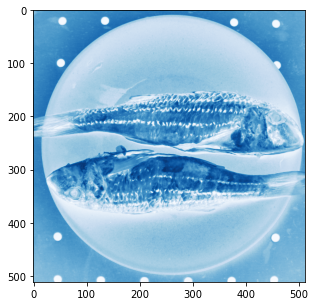

In [19]:
# Get the blue channel
blue_channel = im_array[:,:,2]
w,h = blue_channel.shape
blue_channel_vec = np.reshape(blue_channel,(w*h))

# Print some pixels values
#print(blue_channel[:10,:10])

plt.figure(1,figsize=(5,5))
plt.imshow(blue_channel,cmap='Blues')

#### Key-dependent pixel permutation

In [20]:
# Perform a pseudo random permutation
np.random.seed(np.mod(key_int,4294967295))
index_perm = np.random.permutation(w*h)

#print(index_perm[:10])

In [21]:
blue_perm = blue_channel_vec[index_perm]

#print(blue_perm[:100])

#### Recovery of least significant bits

In [22]:
# Get the LSBs
lsb = blue_perm&1

#print(lsb[:100])

#### Message insertion 

In [23]:
# Write the size on the first 32 bits
lsb[:32]= list(np.binary_repr(nb_bits, width=32))
# Write the message after
lsb[32:32+nb_bits] = list(bits)

# LSB substitution
blue_perm_stego = (blue_perm & ~1) | lsb

#print(blue_perm_stego[:100])

#print(blue_perm_stego[:100]-blue_perm[:100])

#### Inverse permutation and blue channel substitution

In [24]:
blue_stego = np.zeros((w*h))
# Inverse permutation
blue_stego[index_perm] = blue_perm_stego
blue_stego = np.reshape(blue_stego,(w,h))
blue_stego = blue_stego.astype(dtype=np.uint8)
im_stego[:,:,2] = blue_stego

#### Recording, insertion rate calculation, display

Embedding rate:
 0.012470245361328125 bits per pixel (bpp)



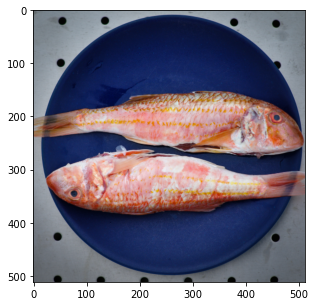

In [26]:
# Save and show the stego picture
im_stego_png = Image.fromarray(im_stego)
im_stego_png.save(stego_path)

# Display the stego image
plt.figure(2, figsize=(5, 5))
plt.imshow(im_stego)

# Print embedding rate
print('Embedding rate:\n', float(nb_bits + 32) / (3 * h * w), 'bits per pixel (bpp)\n')


#### Different image

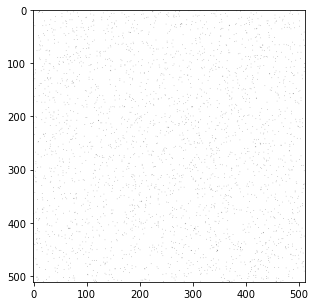

In [27]:
# Show the difference

plt.figure(1,figsize=(5,5))
plt.imshow(blue_stego-blue_channel,cmap='Greys')

#### Message decoding

In [28]:
# Decode

# Open the image
pil_image = Image.open(stego_path)
im_array = np.asarray(pil_image)

# Use a key
key = 'azerty'

# Convert the key to bits, then to an integer

#key_unicode = unicode(key, "utf-8")
#bits_key = '{:b}'.format(int(key_unicode.encode('utf-8').encode('hex'), 16))
#key_int = sum(map(lambda x: x[1]*(2**x[0]), enumerate(map(int, str(bits_key))[::-1])))

key_int = hash(key)
#print(key_int)

# Get the blue channel
blue_channel_test = im_array[:,:,2]
w,h = blue_channel_test.shape
blue_channel_vec = np.reshape(blue_channel_test,(w*h))
    
# Perform a pseudo random permutation
np.random.seed(np.mod(key_int,4294967295))
index_perm = np.random.permutation(w*h)
blue_perm = blue_channel_vec[index_perm]

#Get the message size from the first 32 bits
nb_bits = int(str(blue_perm[:32]&1).replace('[','').replace(']','').replace(' ',''),2)
#print(nb_bits)

In [29]:
# If message size larger than image size, extract at maximum capacity
if nb_bits>h*w : nb_bits = h*w-32

# Get the pixels encoding the message
blue_perm_new = blue_perm[32:32+nb_bits]
# Get the LSBs
# TO DO
# for example lsb = [1 0 0 ... 1 1 0]

lsb=blue_perm_new&1

# Convert the lsb to string
bit_string2 = lsb.tostring()
bit_str = '0b'
for i in range(len(lsb)):
    #print(lsb[i])
    if lsb[i]==0:
        bit_str=bit_str+'0'
    else:
        bit_str=bit_str+'1'



n = int(bit_str, 2)

n.to_bytes((n.bit_length() + 7) // 8, 'big').decode()

<ipython-input-29-3e2f961843a4>:13: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  bit_string2 = lsb.tostring()


'CRIStAL (Center for Research in Computing, Signal, and Automatics of Lille) is a mixed research unit (UMR 9189) resulting from the merger of LAGIS (Laboratory of Automatics, Computer Engineering, and Signal - UMR 8219) and LIFL (Laboratory of Fundamental Computer Science of Lille - UMR 8022) to bring together their complementary skills in information sciences. CRIStAL was born on January 1, 2015, under the supervision of CNRS, University of Lille 1, and École Centrale de Lille in partnership with University of Lille 3, Inria, and Institut Mines Telecom. CRIStAL is a member of the interdisciplinary research institute IRCICA – USR CNRS 3380 (www.ircica.univ-lille1.fr). The unit consists of nearly 430 members (222 permanent and over 200 non-permanent), including 22 permanent CNRS members and 27 permanent Inria members. The research activities of CRIStAL focus on themes related to current major scientific and societal challenges such as Big Data, software, image and its uses, human-machin

# Quantitative steganalysis: estimating message size

In [30]:
# Get the image
pil_image = Image.open('./stego.png')


im_array = np.asarray(pil_image)
im_stego = np.copy(im_array)

Im = im_array[:,:,2]

# Get pairs of neighboring pixels
R = Im[:,:-1]
S = Im[:,1:]

width, height = S.shape

size = float(width * height)

im_stego = S.astype(float)
im_Diff = S.astype(float) - R.astype(float)

# print out the values obtained for the five cardinals (Z,W,X,V,P)
Z=[]
W=[]
X=[]
V=[]
P=[]
for i in range(len(R)):
    for j in range(len(R[0])):
        if R[i][j]==S[i][j]:
            Z.append([R[i][j],S[i][j]])
        if (S[i][j]%2==0 and R[i][j]==S[i][j]+1) or (S[i][j]%2==1 and R[i][j]==S[i][j]-1):
            W.append([R[i][j],S[i][j]])
        if (R[i][j]<S[i][j] and S[i][j]%2==0) or (R[i][j]>S[i][j] and S[i][j]%2==1):
            X.append([R[i][j],S[i][j]])
        if (S[i][j]%2==1 and R[i][j]<S[i][j]-1) or (S[i][j]%2==0 and R[i][j]>S[i][j]+1):
            V.append([R[i][j],S[i][j]])
P=Z+W+X+V

a=2*(len(W)+len(Z))
b=2*(2*len(X)-len(P))
c=len(V)+len(W)-len(X)
delta=b**2-4*a*c


# calcul de l'estimation de p
pEst = (-b - np.sqrt(delta))/(2*a)   

print('estimated message size (bits):' , pEst*2*512**2)  

estimated message size (bits): 8767.558620383634


In [38]:
# Run different embeddings/estimations to evaluation the standard deviation of the empirical estimator

keys=['a','abc','metz','thomas','steganalysis','watermarking','steganography','dpfhcnjedloe','mslcnvhfyruiokshnxkp','podkfkspkdpfksksdfsfsf','dsninfinsidnginsdininnsdn']

def process_steganalysis(key):
    
    print('key : ',key)
    
    
    # Cover file
    image_path = './red_fish.png'
    # Stego file
    stego_path = './stego.png'

    # Open the figure
    pil_image = Image.open(image_path)
    im_array = np.asarray(pil_image)
    im_stego = np.copy(im_array)
    
    
    message = 'CRIStAL (Center for Research in Computing, Signal, and Automatics of Lille) is a mixed research unit (UMR 9189) resulting from the merger of LAGIS (Laboratory of Automatics, Computer Engineering, and Signal - UMR 8219) and LIFL (Laboratory of Fundamental Computer Science of Lille - UMR 8022) to bring together their complementary skills in information sciences. CRIStAL was born on January 1, 2015, under the supervision of CNRS, University of Lille 1, and École Centrale de Lille in partnership with University of Lille 3, Inria, and Institut Mines Telecom. CRIStAL is a member of the interdisciplinary research institute IRCICA – USR CNRS 3380 (www.ircica.univ-lille1.fr). The unit consists of nearly 430 members (222 permanent and over 200 non-permanent), including 22 permanent CNRS members and 27 permanent Inria members. The research activities of CRIStAL focus on themes related to current major scientific and societal challenges such as Big Data, software, image and its uses, human-machine interactions, robotics, control and supervision of large systems, intelligent embedded systems, bioinformatics... with applications notably in the sectors of commerce industry, technologies for health, and smart grids.'
    
    # Convert the message to bits

    message_unicode = str(message)

    bits  = bin(int.from_bytes(message.encode(), 'big'))

    bits = bits[2:]
    
    
    # Convert the key to bits, then to an integer

    key_unicode = str(key)

    key_int = hash(key)  
 
    # Compute the message size
    nb_bits = len(bits)

    print('message size:' , nb_bits)
    
    
    # Get the blue channel
    blue_channel = im_array[:,:,2]
    w,h = blue_channel.shape
    blue_channel_vec = np.reshape(blue_channel,(w*h))
    
    
    # Perform a pseudo random permutation
    np.random.seed(np.mod(key_int,4294967295))
    index_perm = np.random.permutation(w*h)
    
    blue_perm = blue_channel_vec[index_perm]
    
    lsb = blue_perm&1
    
    
    # Write the size on the first 32 bits
    lsb[:32]= list(np.binary_repr(nb_bits, width=32))
    # Write the message after
    lsb[32:32+nb_bits] = list(bits)

    # LSB substitution
    blue_perm_stego = (blue_perm & ~1) | lsb
    
    
    blue_stego = np.zeros((w*h))
    # Inverse permutation
    blue_stego[index_perm] = blue_perm_stego
    blue_stego = np.reshape(blue_stego,(w,h))
    blue_stego = blue_stego.astype(dtype=np.uint8)
    im_stego[:,:,2] = blue_stego
    
    
    # Save and show the stego picture
    im_stego_png = Image.fromarray(im_stego)
    im_stego_png.save(stego_path)
    
    
    # Decode

    # Open the image
    pil_image = Image.open(stego_path)
    im_array = np.asarray(pil_image)

    # Convert the key to bits, then to an integer
  
    key_int = hash(key)

    # Get the blue channel
    blue_channel_test = im_array[:,:,2]
    w,h = blue_channel_test.shape
    blue_channel_vec = np.reshape(blue_channel_test,(w*h))
    
    # Perform a pseudo random permutation
    np.random.seed(np.mod(key_int,4294967295))
    index_perm = np.random.permutation(w*h)
    blue_perm = blue_channel_vec[index_perm]

    #Get the message size from the first 32 bits
    nb_bits = int(str(blue_perm[:32]&1).replace('[','').replace(']','').replace(' ',''),2)

    
    # If message size larger than image size, extract at maximum capacity
    if nb_bits>h*w : 
        nb_bits = h*w-32

    # Get the pixels encoding the message
    blue_perm_new = blue_perm[32:32+nb_bits]
    
    # Get the LSBs
    lsb=blue_perm_new&1

    # Convert the lsb to string
    bit_string2 = lsb.tobytes()
    bit_str = '0b'
    for i in range(len(lsb)):
        #print(lsb[i])
        if lsb[i]==0:
            bit_str=bit_str+'0'
    else:
        bit_str=bit_str+'1'



    n = int(bit_str, 2)

    n.to_bytes((n.bit_length() + 7) // 8, 'big').decode()
    
    
    # Get the image

    pil_image = Image.open('./stego.png')


    im_array = np.asarray(pil_image)
    im_stego = np.copy(im_array)

    Im = im_array[:,:,2]

    # Get pairs of neighboring pixels
    R = Im[:,:-1]
    S = Im[:,1:]

    width, height = S.shape

    size = float(width * height)

    im_stego = S.astype(float)
    im_Diff = S.astype(float) - R.astype(float)

    # print out the values obtained for the five cardinals (Z,W,X,V,P)
    Z=[]
    W=[]
    X=[]
    V=[]
    P=[]
    for i in range(len(R)):
        for j in range(len(R[0])):
            if R[i][j]==S[i][j]:
                Z.append([R[i][j],S[i][j]])
            if (S[i][j]%2==0 and R[i][j]==S[i][j]+1) or (S[i][j]%2==1 and R[i][j]==S[i][j]-1):
                W.append([R[i][j],S[i][j]])
            if (R[i][j]<S[i][j] and S[i][j]%2==0) or (R[i][j]>S[i][j] and S[i][j]%2==1):
                X.append([R[i][j],S[i][j]])
            if (S[i][j]%2==1 and R[i][j]<S[i][j]-1) or (S[i][j]%2==0 and R[i][j]>S[i][j]+1):
                V.append([R[i][j],S[i][j]])
    P=Z+W+X+V

    a=2*(len(W)+len(Z))
    b=2*(2*len(X)-len(P))
    c=len(V)+len(W)-len(X)
    delta=b**2-4*a*c


    # calcul de l'estimation de p
    pEst = (-b - np.sqrt(delta))/(2*a)   

    print('estimated message size (bits):' , pEst*2*512**2)
    
    print('deviation of the empirical estimator (bits):',np.abs(pEst*2*512**2-nb_bits),'\n')
    
    return np.abs(pEst*2*512**2-nb_bits)




In [39]:
estimation_discrepancies = []

for key in keys:
    estimation_discrepancies.append(process_steganalysis(key))
    
print('Mean discrepancy of the empirical estimator: ', statistics.mean(estimation_discrepancies))

key :  a
message size: 9775
estimated message size (bits): 10260.896600970991
deviation of the empirical estimator (bits): 485.89660097099113 

key :  abc
message size: 9775
estimated message size (bits): 10096.776657331047
deviation of the empirical estimator (bits): 321.7766573310473 

key :  metz
message size: 9775
estimated message size (bits): 10718.9711744623
deviation of the empirical estimator (bits): 943.9711744623 

key :  thomas
message size: 9775
estimated message size (bits): 9454.959698939785
deviation of the empirical estimator (bits): 320.0403010602149 

key :  steganalysis
message size: 9775
estimated message size (bits): 9995.998427880777
deviation of the empirical estimator (bits): 220.99842788077694 

key :  watermarking
message size: 9775
estimated message size (bits): 9849.873297419992
deviation of the empirical estimator (bits): 74.87329741999201 

key :  steganography
message size: 9775
estimated message size (bits): 10082.527023774132
deviation of the empirical

# Steganalysis by Learning
## Getting Started:
* Load the features extracted from the Cover and Stego images for d=3 (dimension of the multivariate histogram) and T=3 (threshold).

In [116]:
cover = np.loadtxt(r'C:\Users\thoma\Downloads\TP-IMT-Watermarking-Steganographie\Features\cover-spam-N=3-T=3.csv')
stego = np.loadtxt(r'C:\Users\thoma\Downloads\TP-IMT-Watermarking-Steganographie\Features\stego-0.20-lsb-spam-N=3-T=3.csv')

In [117]:
print(cover.shape)
print(stego.shape)

(10000, 686)
(10000, 686)


The dimension of the features is 686. This dimension corresponds to the histograms obtained from the differentiator filter allowing 2T+1 values for (n+1)-tuples of neighboring pixels (diagonal and horizontal/vertical differentiator filters).

**Train a linear classifier with 5000 images for both training and testing (perform a pseudo-random permutation of the images before training).**

In [118]:
random.shuffle(cover)
random.shuffle(stego)
lda = LDA()
X_train = np.concatenate((cover[:5000],stego[:5000]))

y_train = [0]*5000+[1]*5000
X_test = np.concatenate((cover[5000:],stego[5000:]))
y_test = [0]*5000 + [1]*5000

lda.fit(X_train,y_train)
y_pred = lda.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      5000
           1       0.88      0.92      0.90      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

[[4348  652]
 [ 414 4586]]


**Compare with the features produced for N = 2 and T = 4 (provided), explain the difference in performance.**

In [119]:
cover2 = np.loadtxt(r'C:\Users\thoma\Downloads\TP-IMT-Watermarking-Steganographie\Features\cover-spam-N=2-T=4.csv')
stego2 = np.loadtxt(r'C:\Users\thoma\Downloads\TP-IMT-Watermarking-Steganographie\Features\stego-0.20-lsb-spam-N=2-T=4.csv')

In [120]:
print(cover2.shape)
print(stego2.shape)

(10000, 162)
(10000, 162)


In [121]:
random.shuffle(cover2)
random.shuffle(stego2)
lda = LDA()
X_train = np.concatenate((cover2[:5000],stego2[:5000]))

y_train = [0]*5000+[1]*5000
X_test = np.concatenate((cover2[5000:],stego2[5000:]))
y_test = [0]*5000 + [1]*5000

lda.fit(X_train,y_train)
y_pred = lda.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      5000
           1       0.78      0.79      0.79      5000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

[[3901 1099]
 [1031 3969]]


The difference in performance is due to the fact that these new parameters studied produce fewer data than before (686 vs 162 characteristics). Furthermore, one could think that studying more values does not greatly influence the results because the "interesting" values are the variations of +-1. However, studying more neighboring pixels simultaneously would seem more relevant to detect "suspicious" variations in the least significant bits.